**Load PVEL-AD Data**

In [20]:
import xml.etree.ElementTree as ET
import os
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [21]:
image_folder = 'Dataset/PVEL-AD/trainval/JPEGImages'
xml_folder = f'Dataset/PVEL-AD/trainval/Annotations'

### Read labels

In [130]:
# Read labels corresponding to each image and store in label_dict.
# Remove images with only printing_error, corner, fragment, scratch.
# crack and star_crack merged into crack.

label_dict = {}
for xml_filename in os.listdir(xml_folder):
    if xml_filename.endswith('.xml'):
        xml_filepath = os.path.join(xml_folder, xml_filename)
        root = ET.parse(xml_filepath).getroot()
        img_filename = root.find('filename').text
        labels = []
        for obj in root.iter('object'):
            label_text = obj.find('name').text
            if label_text not in ('printing_error', 'corner', 'fragment', 'scratch'):
                if label_text == 'star_crack':
                    label_text = 'crack'
                labels.append(label_text)
        
        if len(labels) > 0:
            label_dict[img_filename] = tuple(set(labels))

In [131]:
# Total samples

len(label_dict.keys())

4493

In [132]:
# Count images having more than one type of label

multilabel_count = [0 for i in range(13)]

for label in label_dict.values():
    multilabel_count[len(label)] += 1

print('No. of labels      Number of images')
for i, img_count in enumerate(multilabel_count):
    print(f'{i}\t\t\t{img_count}')

No. of labels      Number of images
0			0
1			3898
2			566
3			29
4			0
5			0
6			0
7			0
8			0
9			0
10			0
11			0
12			0


In [133]:
# Count of all unique label combinations

value_counts = Counter(label_dict.values())
for label, count in value_counts.items():
    print(f'{label}: {count}')

('crack',): 575
('short_circuit',): 492
('black_core',): 983
('finger',): 965
('thick_line',): 583
('crack', 'finger'): 378
('crack', 'finger', 'thick_line'): 25
('finger', 'thick_line'): 119
('horizontal_dislocation',): 266
('crack', 'thick_line'): 45
('black_core', 'finger'): 15
('crack', 'black_core'): 7
('crack', 'black_core', 'finger'): 3
('vertical_dislocation',): 34
('black_core', 'thick_line'): 2
('black_core', 'finger', 'thick_line'): 1


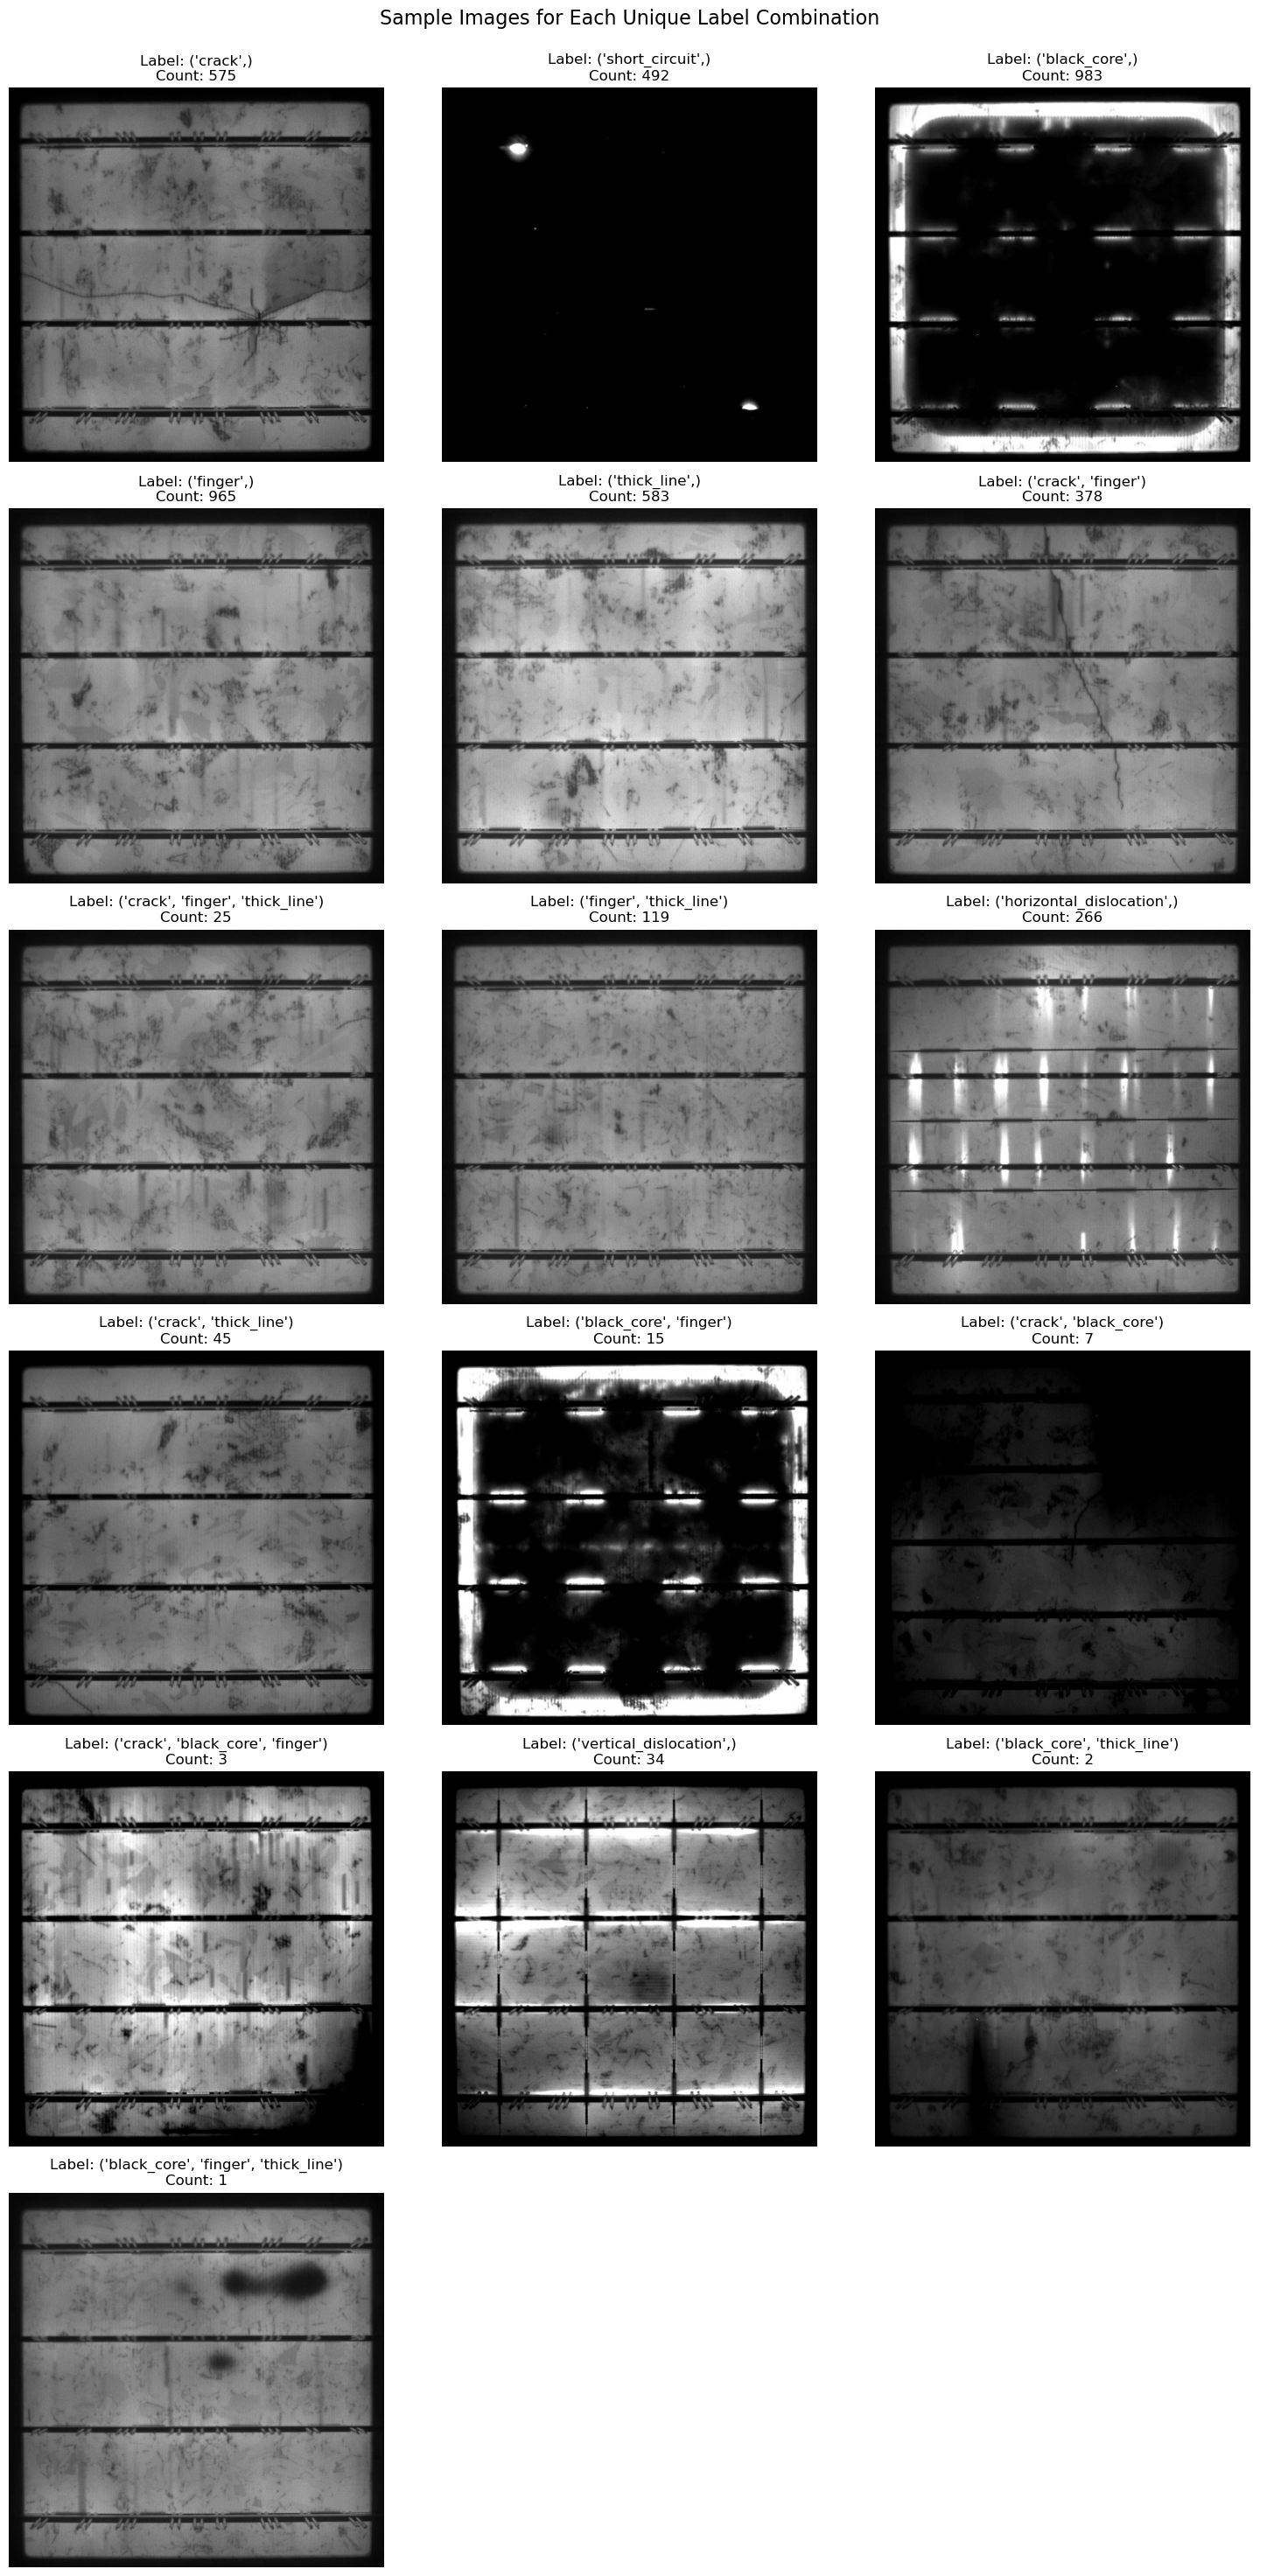

In [134]:
# Sample images for each unique label combination

image_folder = "Dataset/PVEL-AD/trainval/JPEGImages"

# Assuming `label_dict` is your dictionary with image names as keys and label lists as values
value_counts = Counter(map(lambda x: tuple(x), label_dict.values()))

# Set the figure size based on number of unique labels
num_labels = len(value_counts)
cols = 3  # Number of columns in the grid
rows = (num_labels + cols - 1) // cols  # Calculate rows needed

# Create a figure with the appropriate number of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust size as needed
fig.suptitle("Sample Images for Each Unique Label Combination", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Display each unique label's sample image
for idx, (label, count) in enumerate(value_counts.items()):
    # Find an image with the current label combination
    sample_image = next(img for img, lbl in label_dict.items() if tuple(lbl) == label)
    img_path = os.path.join(image_folder, sample_image)
    
    # Read and display the image
    img = mpimg.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(f"Label: {label}\nCount: {count}", fontsize=12)
    axes[idx].axis('off')

# Hide any unused subplots
for ax in axes[num_labels:]:
    ax.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Add some space for the main title
plt.show()

In [135]:
prominent_defect_map = {
    ('crack', 'finger'): 'crack',
    ('crack', 'finger', 'thick_line'): 'crack',
    ('finger', 'thick_line'): 'crack',
    ('crack', 'thick_line'): 'crack',
    ('black_core', 'finger'): 'black_core',
    ('crack', 'black_core'): 'black_core',
    ('crack', 'black_core', 'finger'): 'black_core',
    ('black_core', 'thick_line'): 'black_core',
    ('black_core', 'finger', 'thick_line'): 'black_core'
}

for key, value in label_dict.items():
    if value in prominent_defect_map:
        label_dict[key] = prominent_defect_map[value]
    else:
        label_dict[key] = label_dict[key][0]

In [136]:
# Count of all unique label combinations

value_counts = Counter(label_dict.values())
for label, count in value_counts.items():
    print(f'{label}: {count}')

crack: 1142
short_circuit: 492
black_core: 1011
finger: 965
thick_line: 583
horizontal_dislocation: 266
vertical_dislocation: 34


In [191]:
df = pd.DataFrame(label_dict.items(), columns=['img_filename', 'label'])
df

,img_filename,label
0,img001445.jpg,crack
1,img000983.jpg,crack
2,img023182.jpg,short_circuit
3,img003252.jpg,black_core
4,img003534.jpg,black_core
...,...,...
4488,img000024.jpg,finger
4489,img002633.jpg,crack
4490,img002155.jpg,thick_line
4491,img021954.jpg,short_circuit


In [200]:
# Apply one-hot encoding to label column

ohe = OneHotEncoder()
label_ohe = ohe.fit_transform(np.reshape(np.array(df['label']), (-1,1)))

df_label_ohe = pd.DataFrame(label_ohe.toarray(), 
                            columns=pd.Series(ohe.get_feature_names_out()).str.split('_', 1).str[1], 
                            dtype=int)

df1 = pd.concat([df, df_label_ohe], axis=1)
df1.drop(columns=['label'], inplace=True)
df1

,img_filename,black_core,crack,finger,horizontal_dislocation,short_circuit,thick_line,vertical_dislocation
0,img001445.jpg,0,1,0,0,0,0,0
1,img000983.jpg,0,1,0,0,0,0,0
2,img023182.jpg,0,0,0,0,1,0,0
3,img003252.jpg,1,0,0,0,0,0,0
4,img003534.jpg,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4488,img000024.jpg,0,0,1,0,0,0,0
4489,img002633.jpg,0,1,0,0,0,0,0
4490,img002155.jpg,0,0,0,0,0,1,0
4491,img021954.jpg,0,0,0,0,1,0,0
